In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0003559,ISIC_0025810,bkl,consensus,75.0,male,face
1,HAM_0004240,ISIC_0032517,mel,histo,50.0,male,back
2,HAM_0002610,ISIC_0026876,vasc,consensus,0.0,female,abdomen
3,HAM_0003229,ISIC_0031140,bcc,histo,60.0,male,chest
4,HAM_0005963,ISIC_0028129,nv,follow_up,45.0,male,foot


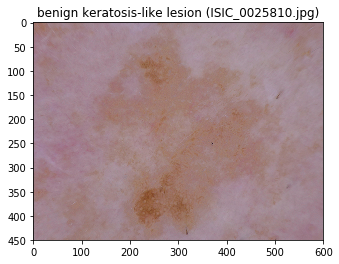

In [2]:
## modified from jupyterhub homework
metadata_path = './skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
metadat = pd.read_csv(metadata_path)
num_samples = len(metadat)
metadat = metadat.sample(frac=1,random_state=12).reset_index(drop=True) #shuffling data

tmp = plt.imread('./train/bkl/ISIC_0025810.jpg')
plt.imshow(tmp)
plt.title('benign keratosis-like lesion (ISIC_0025810.jpg)')
#metadat = metadat['image_id'].add('.jpg')
metadat.head()

In [3]:
# Use 20% test split (80% training + validation)
ntrain2 = int(len(metadat)*0.8)
ntrain1 = int(ntrain2*0.8)
x_test = metadat.iloc[ntrain2:,:]
x_train = metadat.iloc[:ntrain1,:]
x_val = metadat.iloc[ntrain1:ntrain2,:]

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(299, 299),
        batch_size=64,
        seed=12)

validation_generator = val_datagen.flow_from_directory(
        './val',
        target_size=(299, 299),
        batch_size=64,
        seed=12)

test_generator = test_datagen.flow_from_directory(
        './test',
        target_size=(299, 299),
        batch_size=64,
        seed=12)

Found 4653 images belonging to 7 classes.
Found 1830 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


In [4]:
## adapted from keras application example

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from tensorflow.keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [5]:
# create the base pre-trained model
name = "incV3_50e_dorlr"
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer with 7 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# # first: train only the top layers (which were randomly initialized)
# # i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False

# # compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer=RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0), loss='categorical_crossentropy',
#               metrics=['acc'])

# # train the model on the new data for a few epochs
# history1 = model.fit_generator(train_generator,
#         steps_per_epoch=4683//64,
#         epochs=25,
#         validation_data=validation_generator,
#         validation_steps=1602//64)

# ## TRAINING BELOW DOES NOT SIGNIFICANTLY AFFECT ACCURACY OF MODEL ###

# # at this point, the top layers are well trained and we can start fine-tuning
# # convolutional layers from inception V3. We will freeze the bottom N layers
# # and train the remaining top layers.

# # let's visualize layer names and layer indices to see how many layers
# # we should freeze:
# # for i, layer in enumerate(base_model.layers):
# #    print(i, layer.name)

# # we chose to train the top 2 inception blocks, i.e. we will freeze
# # the first 249 layers and unfreeze the rest:
# for layer in model.layers[:249]:
#    layer.trainable = False
# for layer in model.layers[249:]:
#    layer.trainable = True

# we need to recompile the model for these modifications to take effect
model.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=16/30, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=['acc'])

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

checkpoint = ModelCheckpoint("./models/" + name + ".h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2 = model.fit_generator(train_generator,
        steps_per_epoch=len(train_generator),
        epochs=50,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks = [checkpoint, reduce_lr])

Epoch 1/50
73/73 [==============================] - 213s 3s/step - loss: 2.1220 - acc: 0.1666 - val_loss: 1.8826 - val_acc: 0.2284

Epoch 00001: val_acc improved from -inf to 0.22842, saving model to ./models/incV3_50e_dorlr.h5
Epoch 2/50
73/73 [==============================] - 195s 3s/step - loss: 2.0606 - acc: 0.1821 - val_loss: 1.8416 - val_acc: 0.2645

Epoch 00002: val_acc improved from 0.22842 to 0.26448, saving model to ./models/incV3_50e_dorlr.h5
Epoch 3/50
73/73 [==============================] - 197s 3s/step - loss: 2.0191 - acc: 0.1987 - val_loss: 1.8157 - val_acc: 0.3055

Epoch 00003: val_acc improved from 0.26448 to 0.30546, saving model to ./models/incV3_50e_dorlr.h5
Epoch 4/50
73/73 [==============================] - 203s 3s/step - loss: 1.9736 - acc: 0.2108 - val_loss: 1.7953 - val_acc: 0.3175

Epoch 00004: val_acc improved from 0.30546 to 0.31749, saving model to ./models/incV3_50e_dorlr.h5
Epoch 5/50
73/73 [==============================] - 207s 3s/step - loss: 1.9801

73/73 [==============================] - 196s 3s/step - loss: 1.7361 - acc: 0.3281 - val_loss: 1.6070 - val_acc: 0.4607

Epoch 00038: val_acc did not improve from 0.46885

Epoch 00038: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 39/50
73/73 [==============================] - 194s 3s/step - loss: 1.7272 - acc: 0.3280 - val_loss: 1.6039 - val_acc: 0.4672

Epoch 00045: val_acc did not improve from 0.46885
Epoch 46/50
73/73 [==============================] - 195s 3s/step - loss: 1.7375 - acc: 0.3182 - val_loss: 1.6071 - val_acc: 0.4579

Epoch 00046: val_acc did not improve from 0.46885
Epoch 47/50
73/73 [==============================] - 198s 3s/step - loss: 1.7325 - acc: 0.3234 - val_loss: 1.6089 - val_acc: 0.4612

Epoch 00047: val_acc did not improve from 0.46885
Epoch 48/50
73/73 [==============================] - 202s 3s/step - loss: 1.7441 - acc: 0.3250 - val_loss: 1.6104 - val_acc: 0.4634

Epoch 00048: val_acc did not improve from 0.46885
Epoch 49/50
73/73 [=============

Normalized confusion matrix
[[0.2  0.11 0.14 0.11 0.23 0.14 0.08]
 [0.23 0.1  0.13 0.16 0.16 0.14 0.08]
 [0.2  0.11 0.16 0.14 0.18 0.11 0.11]
 [0.2  0.09 0.14 0.18 0.18 0.12 0.08]
 [0.16 0.12 0.17 0.14 0.19 0.13 0.08]
 [0.19 0.11 0.16 0.14 0.17 0.11 0.12]
 [0.16 0.1  0.16 0.13 0.18 0.18 0.09]]


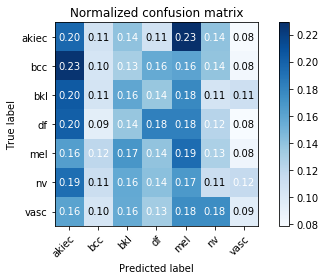

In [6]:
# base_model = InceptionV3(weights='imagenet', include_top=False)

# # add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # let's add a fully-connected layer
# x = Dense(1024, activation='relu')(x)
# # and a logistic layer with 7 classes
# predictions = Dense(7, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)
# model.load_weights("./models/inceptionV3_30e.h5")
# model.compile(optimizer=Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=16/30, amsgrad=False),
#               loss='categorical_crossentropy',
#               metrics=['acc'])

y_pred = model.predict_generator(validation_generator)

y_val = np.ndarray(shape=((len(validation_generator)-1)*64, 7),dtype=int)
for i in range(len(validation_generator)-1):
    y_val[i*64:(i+1)*64][:] = validation_generator[i][1]

# make confusion matrix
lab = np.argmax(y_val,axis=1)
pred = np.argmax(y_pred,axis=1)
cm = np.zeros((7,7))
for i in range(len(lab)):
    cm[lab[i]][pred[i]] += 1

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array(['akiec','bcc','bkl','df','mel','nv','vasc'])
np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plot_confusion_matrix(cm, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(name + '_conf_mat.png')
plt.show()

In [7]:
cm

array([[42., 23., 30., 23., 49., 30., 17.],
       [52., 24., 30., 36., 37., 32., 19.],
       [76., 39., 59., 51., 66., 39., 41.],
       [41., 19., 28., 37., 37., 25., 16.],
       [60., 44., 62., 51., 71., 47., 31.],
       [38., 22., 31., 28., 33., 22., 23.],
       [34., 22., 33., 28., 37., 37., 20.]])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/opt/conda/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if __name__ == '__main__':


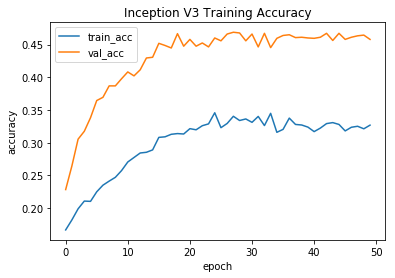

In [8]:
plt.hold(True)
plt.plot(history2.history['acc'],label='train_acc')
plt.plot(history2.history['val_acc'],label='val_acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Inception V3 Training Accuracy')
plt.savefig(name + '_acc.png')
plt.hold(False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/opt/conda/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if __name__ == '__main__':


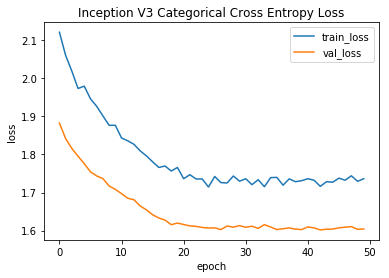

In [9]:
plt.hold(True)
plt.plot(history2.history['loss'],label='train_loss')
plt.plot(history2.history['val_loss'],label='val_loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Inception V3 Categorical Cross Entropy Loss')
plt.savefig(name + '_loss.png')
plt.hold(False)

In [ ]:
np.divide(np.diag(cm),np.sum(cm,1))